# <center> <b> <font color='blue'> SPORTS CELEBRITIES </b> </font> </center>

### TABLE OF CONTENTS

1. [Objectives](#1)
2. [Modules](#2)
3. [Helper Functions](#3)
4. [Loading, exploring and pre-processing data](#4)
5. [PART 1: Feature Extraction](#5)
6. [PART 2: Fine-tuning](#6)
7. [ANNEX](#annex)
8. [References](#references)


<a name="1"></a>
## <b> <font color='#2874A6'> 1. Objectives </b> </font>

Practice with transfer learning.

<a name="2"></a>
## <b> <font color='#2874A6'> 2. Modules </b> </font>

In [5]:
# que no se impriman info y warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras import layers,callbacks,models,Sequential,losses
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras_tuner
from tensorflow import keras
from keras import backend as K
import os,random
import pandas as pd
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers.experimental import preprocessing

<a name="3"></a>
## <b> <font color='#2874A6'> 3. Helper Functions </b> </font>

In [9]:
# plot history
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    plt.legend()

    #plt.figure()
    plt.subplot(1,2,2)
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
    plt.legend()
    plt.show()

<a name="4"></a>
## <b> <font color='#2874A6'> 4. Loading, exploring and pre-processing data </b> </font>

In [13]:
# random seed 
seed_value = 57
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# image shape and batch size
IMG_SHAPE = (224,224)
BATCH_SIZE = 32

### Loading data

<b>Note:</b> This is an image problem for which we're going to use EfficientNet as a base model. In the following code, we're going to use an appropriate built-in pre-processing function responsible for tasks such as rescaling.


In [15]:
! ls data && cd

test  train


In [18]:
train_dir='data/train'
test_dir='data/test'

In [19]:
# data generator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)
        # we're gonna use 20% (0.2) of the data for validation


# train
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # several classes
    subset='training'
)

# validation (uses also train_datagen; it is a subset of the data)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


# for testing
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Found 315 images belonging to 4 classes.
Found 78 images belonging to 4 classes.
Found 50 images belonging to 4 classes.


In [21]:
num_classes = train_generator.num_classes
num_classes

4

Let's see the names of the classes.

In [23]:
# Gets the dictionary that maps class names to their indices.
class_indices = train_generator.class_indices

# Inverts the dictionary to obtain a dictionary that maps indices to class names
indices_to_classes = {v: k for k, v in class_indices.items()}

# Print
class_names = list(indices_to_classes.values())
print("Names of the classes:", class_names)

Names of the classes: ['Kane Williamson', 'Kobe Bryant', 'Maria Sharapova', 'Ronaldo']


### Pre-processing

In [24]:
# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet's having resclaing built-in
], name="data_augmentation")

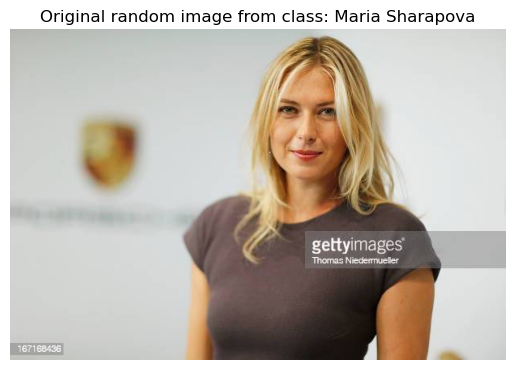

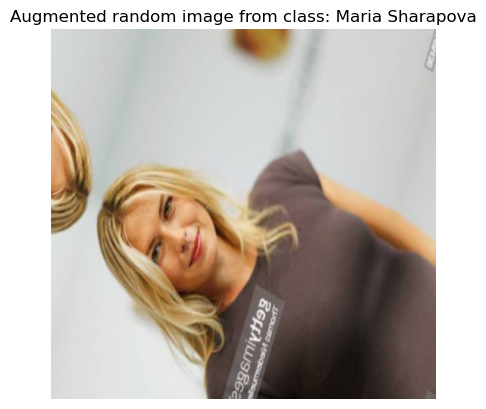

In [26]:
target_class = random.choice(class_names)
target_dir = "data/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image


# Read and plot in the random image 
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

<a name="5"></a>
## <b> <font color='#2874A6'> 5. PART 1. Feature Extraction </b> </font>

Our model will be:

- EfficientNet + GlobalAveragePooling2D + Output Dense

In [45]:
input_shape = IMG_SHAPE+(3,)


# base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# create inputs into our model
inputs = tf.keras.layers.Input(shape=input_shape,name='input_layer')

# add in data augmentation Sequential model as a layer
x = data_augmentation(inputs,training=True)

# pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# global average pooling
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# output
outputs = tf.keras.layers.Dense(num_classes,activation='softmax',name='output_layer')(x)
# comibne the inputs and the outputs into a model
model = tf.keras.Model(inputs,outputs)


# compile
model.compile(loss="categorical_crossentropy", # labels are one-hot encoded
            optimizer=tf.keras.optimizers.Adam(),
            metrics=["accuracy"])
    


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)


In [46]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4054695 (15.47 MB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________

In [47]:
# Check the layers in our model
for layer_number, layer in enumerate(model.layers):
  print(layer_number, layer.name)

0 input_layer
1 efficientnetb0
2 global_average_pooling_layer
3 output_layer


In [48]:
# first 10 layers in efficient net
for layer in model.layers[1].layers[:10]:
    print(layer.name, layer.trainable)

input_3 False
rescaling_4 False
normalization_2 False
rescaling_5 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False


In [49]:
# fit
history = model.fit(train_generator,
                     epochs=10,
                     steps_per_epoch=len(train_generator),
                     validation_data=validation_generator,
                     validation_steps=len(validation_generator))

Epoch 1/10
10/10 [==============================] - 18s 1s/step - loss: 1.1894 - accuracy: 0.4952 - val_loss: 1.0029 - val_accuracy: 0.7051
Epoch 2/10
10/10 [==============================] - 11s 1s/step - loss: 0.8710 - accuracy: 0.7683 - val_loss: 0.8073 - val_accuracy: 0.8077
Epoch 3/10
10/10 [==============================] - 12s 1s/step - loss: 0.6758 - accuracy: 0.8413 - val_loss: 0.6882 - val_accuracy: 0.8077
Epoch 4/10
10/10 [==============================] - 12s 1s/step - loss: 0.5506 - accuracy: 0.8857 - val_loss: 0.6128 - val_accuracy: 0.8333
Epoch 5/10
10/10 [==============================] - 13s 1s/step - loss: 0.4609 - accuracy: 0.9016 - val_loss: 0.5623 - val_accuracy: 0.8333
Epoch 6/10
10/10 [==============================] - 13s 1s/step - loss: 0.3921 - accuracy: 0.9206 - val_loss: 0.5255 - val_accuracy: 0.8590
Epoch 7/10
10/10 [==============================] - 15s 2s/step - loss: 0.3372 - accuracy: 0.9492 - val_loss: 0.5026 - val_accuracy: 0.8718
Epoch 8/10
10/10 [==

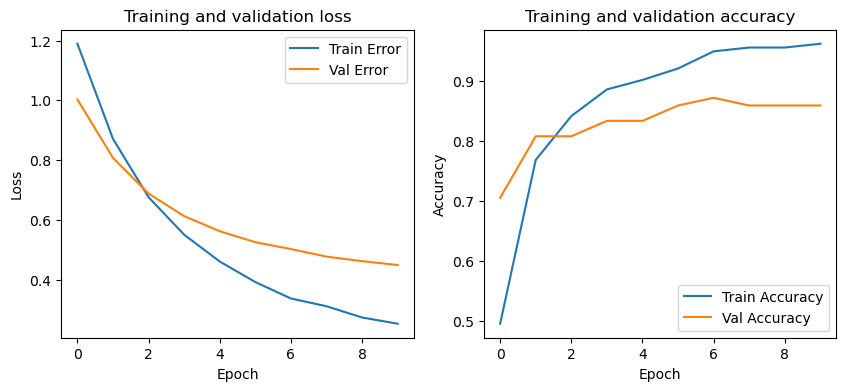

In [50]:
plot_history(history)

In [51]:
scores = model.evaluate(test_generator)

2/2 [==============================] - 2s 464ms/step - loss: 0.4861 - accuracy: 0.8000


<a name="6"></a>
## <b> <font color='#2874A6'> 6. PART 2. Fine-tuning </b> </font>

Once the model has converged with the new data, you can attempt to unfreeze all or part of the base model and retrain the model with a very small learning rate. This can lead to significant improvements but also increase the risk of rapid overfitting, so keep this in mind.

It is critical to perform this step only after the model with the frozen layers has been trained to convergence. If you mix randomly initialized trainable layers with trainable layers that have pre-trained characteristics, the randomly initialized layers will cause large gradient updates during training, which will destroy their pre-trained characteristics.

It is also critical to use a very small learning rate at this stage because you are training a much larger model than in the initial stage, on a dataset that is typically small. Therefore, there is a risk of quickly falling into overfitting if you apply large weight updates. Here, you only want to adapt the pre-trained weights incrementally.

In [52]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

for layer in base_model.layers[:-10]: # Freeze all layers except for the last 10
  layer.trainable = False

# recompile
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # when fine-tuning you typically want to lower the learning rate by 10x*
                metrics=["accuracy"])

In [53]:
# callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience = 5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


# fit
history = model.fit(train_generator,
                     epochs=10,
                     steps_per_epoch=len(train_generator),
                     validation_data=validation_generator,
                     validation_steps=len(validation_generator),
                     callbacks=[early_stopping,reduce_lr],
                     verbose=0)

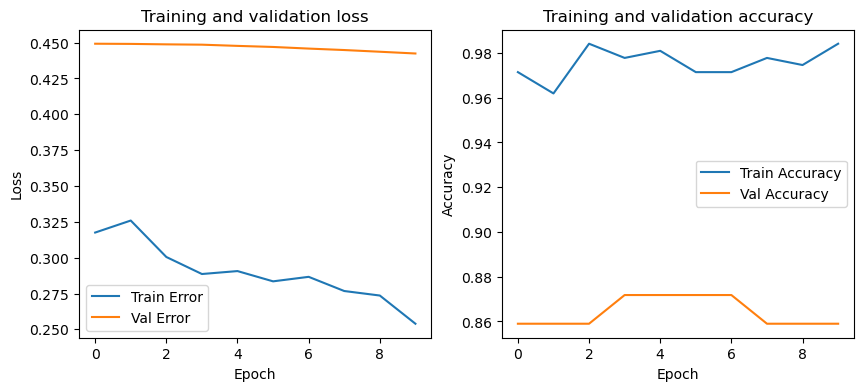

In [54]:
plot_history(history)

We have a clear case of overfitting. Some options to improve this situation are:

- Get more data.
- Using a base model less complex than EfficientNet.

In [56]:
scores = model.evaluate(test_generator)

2/2 [==============================] - 2s 531ms/step - loss: 0.4503 - accuracy: 0.8400


<a name="annex"></a>
## <b> <font color='#2874A6'> ANNEX </b> </font>

About types of transfer learning:
    
- Feature Extraction
- Fine-tuning


<b>Feature Extraction:</b> 

- In this step, we use the pre-trained model as a fixed feature extractor. We remove the final layers responsible for classification and replace them with new layers that are specific to our task. The pre-trained model’s weights are frozen, and only the weights of the newly added layers are trained on the smaller dataset.

<b> Fine-Tuning: </b> 

- Fine-tuning takes the process a step further by unfreezing some of the pre-trained model’s layers and allowing them to be updated with the new dataset. This step enables the model to adapt and learn more specific features related to the new task or domain.



<a name="references"></a>
## <b> <font color='#2874A6'> References </b> </font>

- [Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning)
- [TF Advanced Techniques Specialization](https://www.coursera.org/specializations/tensorflow-advanced-techniques)
